# Assignment 2: deep learning on images

This report consists of 2 parts. The first part is mostly the overall code of solving the learning task, with brief markdowns or comments to explain what is done in each cell. The second part is the discussion with a more detailed explanation of what is done and the results.

In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import os

In [30]:
# Convert the json file into dataframe
dataset=pd.read_json("/kaggle/input/dataset/dataset.json")
dataset.head()

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
0,2805630,2024-02-24,BotMobile,1173,Positive,10.0,100.0,"[Action, Action-Adventure, Adventure, Casual, ...",[2805630_ss_02b69bffacf19807fb6202fb8167fad7e0...
1,2805610,2024-02-24,Just skill shooter 3: 2d edition,199,Positive,11.0,90.0,"[2D, Action, Action RPG, Action-Adventure, Adv...",[2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758d...
2,2816420,2024-02-24,Slime Drop,199,None,NaN,NaN,"[2D, Arcade, Casual, Clicker, Colorful, Cute, ...",[2816420_ss_649a6c5bb66b93bf7b0a384d412923618d...
3,2815670,2024-02-24,Path to the Creator,299,None,NaN,NaN,"[2D, Action RPG, Adventure, Character Customiz...",[2815670_ss_06c8a39fd0618390bdedaff037f2463ca4...
4,2776190,2024-02-24,Crowd Control VR,1179,None,NaN,NaN,"[360 Video, Arcade, Cartoony, Casual, Fantasy,...",[2776190_ss_01d6152f8e559e051312ea5e6232ba1ecb...


In [31]:
# Replace the .jpg filename into .webp for each image filename
def replace_extension(img_list):
    return [filename.replace('.jpg', '.webp') for filename in img_list]

# Applying the function to the 'screenshots' column
dataset['screenshots'] = dataset['screenshots'].apply(replace_extension)

# Print the updated dataset
print(dataset['screenshots'][0])

['2805630_ss_02b69bffacf19807fb6202fb8167fad7e08eae77.1920x1080.webp', '2805630_ss_67edf620e44492c0110912c2a6672113011aa94c.1920x1080.webp', '2805630_ss_790259f92a9ba5f506a00eafc9efa4fb2dc9686d.1920x1080.webp', '2805630_ss_a25f2dcb34e2688eaa6c9a971c38a03dbdab18fb.1920x1080.webp', '2805630_ss_b8fb2eff1ddc2816f0ec744d467ab3dfe9d584e1.1920x1080.webp', '2805630_ss_c1a17e1b1ca267e911de2948f426b34b07cca172.1920x1080.webp', '2805630_ss_c96c5067160ab0a5eeb71142478872313ee4d234.1920x1080.webp', '2805630_ss_fc7976bb6906578e962c52d4952a5b4184351d1c.1920x1080.webp']


We prepend each image filename into full path name in Kaggle. It's because we need to load the images from image file paths stored in Kaggle input section later on when we created data batch using the custom data generator.

In [32]:
# Function to prepend folder name to each screenshot
folder_name = "/kaggle/input/pictures/images/"
def prepend_folder_name(screenshot_list):
    return [folder_name + screenshot for screenshot in screenshot_list]
dataset['image_path']=dataset['screenshots'].apply(prepend_folder_name)
dataset['image_path'][0]

['/kaggle/input/pictures/images/2805630_ss_02b69bffacf19807fb6202fb8167fad7e08eae77.1920x1080.webp',
 '/kaggle/input/pictures/images/2805630_ss_67edf620e44492c0110912c2a6672113011aa94c.1920x1080.webp',
 '/kaggle/input/pictures/images/2805630_ss_790259f92a9ba5f506a00eafc9efa4fb2dc9686d.1920x1080.webp',
 '/kaggle/input/pictures/images/2805630_ss_a25f2dcb34e2688eaa6c9a971c38a03dbdab18fb.1920x1080.webp',
 '/kaggle/input/pictures/images/2805630_ss_b8fb2eff1ddc2816f0ec744d467ab3dfe9d584e1.1920x1080.webp',
 '/kaggle/input/pictures/images/2805630_ss_c1a17e1b1ca267e911de2948f426b34b07cca172.1920x1080.webp',
 '/kaggle/input/pictures/images/2805630_ss_c96c5067160ab0a5eeb71142478872313ee4d234.1920x1080.webp',
 '/kaggle/input/pictures/images/2805630_ss_fc7976bb6906578e962c52d4952a5b4184351d1c.1920x1080.webp']

In [33]:
dataset = dataset[['appid','price','image_path']]
dataset

,appid,price,image_path
0,2805630,1173,[/kaggle/input/pictures/images/2805630_ss_02b6...
1,2805610,199,[/kaggle/input/pictures/images/2805610_ss_21f5...
2,2816420,199,[/kaggle/input/pictures/images/2816420_ss_649a...
3,2815670,299,[/kaggle/input/pictures/images/2815670_ss_06c8...
4,2776190,1179,[/kaggle/input/pictures/images/2776190_ss_01d6...
...,...,...,...
14682,2180890,498,[/kaggle/input/pictures/images/2180890_ss_65cc...
14683,2782420,589,[/kaggle/input/pictures/images/2782420_ss_1221...
14684,2836310,779,[/kaggle/input/pictures/images/2836310_ss_44ad...
14685,2626240,1479,[/kaggle/input/pictures/images/2626240_ss_45a4...


Since the dataset is too large, and our computational ability is limited, we created a subset and will later use the pre-trained model to fit our model. 
We categorize the prize into bins and sample within each bin, so that the subset we create will not have an imbalanced target.

In [83]:
# Categorize price into bins and then sample within each bin
dataset['price_category'] = pd.qcut(dataset['price'], q=10, duplicates='drop')  #'q' is based on how fine-grained the bins are
subset_df = dataset.groupby('price_category').apply(lambda x: x.sample(frac=0.01, random_state=1)).reset_index(drop=True) # 'frac' can be modified to sample how big the subset it will be based on the computational time

/tmp/ipykernel_33/822136844.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset_df = dataset.groupby('price_category').apply(lambda x: x.sample(frac=0.01, random_state=1)).reset_index(drop=True) # 'frac' can be modified to sample how big the subset it will be based on the computational time
/tmp/ipykernel_33/822136844.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = dataset.groupby('price_category').apply(lambda x: x.sample(frac=0.01, random_state=1)).reset_index(drop=True) # 'frac' can

In [84]:
len(subset_df)

147

Here we can show a boxplot to see the distribution of price. We would not remove any outliers here because the price range here is reasonable.

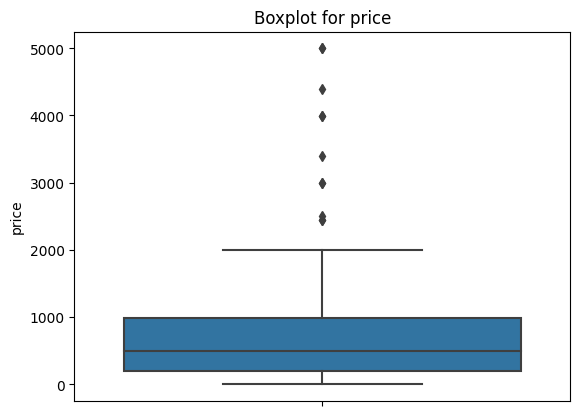

In [85]:
import seaborn as sns

# Create a boxplot for column price
sns.boxplot(y=subset_df['price'])
plt.title('Boxplot for price')
plt.show()

In [86]:
print(subset_df['price'].min())
print(subset_df['price'].max())

0
4999


We can open a photo to check how it would look like by resizing it.

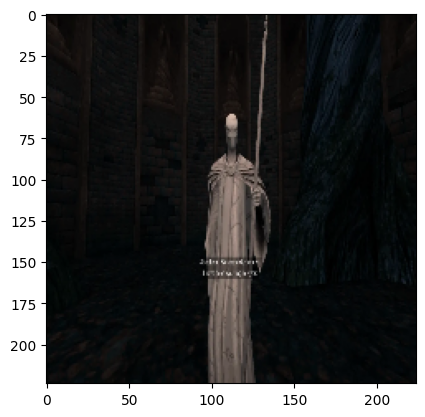

In [38]:
import cv2
file_path = '/kaggle/input/pictures/images/1000410_ss_e2caa831925864698c5b7f6909cb356864b5e94a.1920x1080.webp'
with Image.open(file_path) as img:
    image = np.asarray(img, dtype="uint8")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize the image to 224x224 pixels size
    image_224x224 = cv2.resize(image_rgb, (224, 224))
    plt.imshow(image_224x224)

In [87]:
# Check if there are duplicated records
print('There are {} unique records.'.format(len(subset_df['appid'].unique())))

There are 147 unique records.


We split the subset into training, validation and test dataset based on the ratio of 0.6:0.2:0.2.

In [88]:
from sklearn.model_selection import train_test_split
# Split into training and test sets at the game level
train_val_indices, test_indices = train_test_split(subset_df.index, test_size=0.2, random_state=42)
# Split into training and validation sets at the game level
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.25, random_state=42)

In [89]:
train_games = subset_df.loc[train_indices]
test_games = subset_df.loc[test_indices]
val_games = subset_df.loc[val_indices]

In [90]:
print(len(train_games))
print(len(val_games))
print(len(test_games))

87
30
30


As the input for Convolutional Neural Network (CNN) should have the input shape of only (width,height,channels), so we expand the dataframe to separate each image into a row. We creat a user defined funtion to operate this step because we need to apply this function to all training, validation and test set. We have to do this step after spliting the dataset in case there would be data leakage. 

In [91]:
# Duplicate rows and expand the "image_array" column
def expand_dataframe(df):
    expanded_data = []
    for index, row in df.iterrows():
        for img in row['image_path']:
            expanded_data.append([row['appid'],row['price'], img])

    # Create a new DataFrame with the expanded data
    expanded_data = pd.DataFrame(expanded_data, columns=['appid','price', 'image_path'])
    return expanded_data

In [92]:
train_games_expanded = expand_dataframe(train_games)
test_games_expanded = expand_dataframe(test_games)
val_games_expanded = expand_dataframe(val_games)

In [93]:
train_games_expanded

,appid,price,image_path
0,2614510,0,/kaggle/input/pictures/images/2614510_ss_29739...
1,2614510,0,/kaggle/input/pictures/images/2614510_ss_80a92...
2,2614510,0,/kaggle/input/pictures/images/2614510_ss_b2070...
3,2614510,0,/kaggle/input/pictures/images/2614510_ss_b6fec...
4,2614510,0,/kaggle/input/pictures/images/2614510_ss_ea589...
...,...,...,...
789,2359760,299,/kaggle/input/pictures/images/2359760_ss_9108c...
790,2359760,299,/kaggle/input/pictures/images/2359760_ss_a0f12...
791,2359760,299,/kaggle/input/pictures/images/2359760_ss_adece...
792,2359760,299,/kaggle/input/pictures/images/2359760_ss_edf62...


In [94]:
print(len(val_games_expanded))
print(len(test_games_expanded))

235
261


This step we create a user defined function for loading and preprocessing the image. As decoding .webp file would return a 4-channel shape (rgba), we need to convert it to a 3-channel shape (rgb). We resize the image to (224,224) to fit the input shape for VGG16. The last step for preprocessing the image is normalizing the image into [0,1]. We also apply data augmentation, including random flipping, rotation by 90 degrees, changing the brightness, changing the contrast, changing the saturation, and cropping. In order to improve the efficiency and save the computational resources, we create batches for dataset.

In [96]:
import tensorflow as tf
import tensorflow_io as tfio

def load_and_preprocess_image(file_path, size=(224, 224)):
    try:
        # Read the image file
        image = tf.io.read_file(file_path)

        # Decode the .webp file
        image = tfio.image.decode_webp(image)
        # After decoding, it returns a shape with 4 channels. We need to convert to rgb image to match the input for CNN model.
        image = tfio.experimental.color.rgba_to_rgb(image)

        # Resize the image to match the input size expected by the model
        image = tf.image.resize(image, size)

        # Apply normalization
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1] 

        return image
    except Exception as e:
        # A failure note if not open successfully
        print(f"Failed to process {file_path}: {e}")
        return None

In [97]:
# Data augmentation
def augment_image(image):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)

    # Randomly rotate the image
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Randomly change the brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Randomly change the contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Randomly change the saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Randomly crop the image
    image = tf.image.resize_with_crop_or_pad(image, 250, 250)
    image = tf.image.random_crop(image, size=[224, 224, 3])
    
    return image

In [98]:
def process_path(file_path, label):
    # Convert and preprocess the image
    img = load_and_preprocess_image(file_path)
    return img, label

def prepare_dataset(df, batch_size, augment=False):
    # Create a dataset of file paths and labels
    filenames = df['image_path'].values
    labels = df['price'].values  # or whatever your target variable is
    labels = np.array(labels, dtype=np.float32)  # Make sure labels are float for regression
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    # Map the `process_path` function to each item in the dataset
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply data augmentation if required
    if augment:
        dataset = dataset.map(lambda x, y: (augment_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch to optimize performance
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [99]:
# Generate batched data
train_dataset = prepare_dataset(train_games_expanded, batch_size=32, augment=True)
val_dataset = prepare_dataset(val_games_expanded, batch_size=32, augment=False)

We choose VGG16 as the pre-trained model. We freeze the layers of the pre-trained model so that the weights of these layers will not be updated during the training process. Then we add several fully connected layers on top of it, including global average pooling, dense layers with ReLU activations, dropout for regularization, a final dense layer with a linear activation for the regression output. The final model is created and compiled with the Adam optimizer and mean squared error loss function.

In [100]:
from tensorflow.keras.applications.vgg16 import VGG16

pre_trained_model = VGG16(
                    weights='imagenet',
                    input_shape=(224, 224, 3),
                    include_top=False)  

for layer in pre_trained_model.layers:
    layer.trainable = False

In [101]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

x = pre_trained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='linear')(x)

model = Model(pre_trained_model.input, x)

optimizer = Adam(0.001)
model.compile(optimizer=optimizer,
              loss='mean_squared_error', 
              metrics=['mean_squared_error'])

We create a callback with ModelCheckpoint and EarlyStopping.

In [102]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("game_price_regression.keras",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
callbacks = [earlystop, checkpoint]

We set batch size as 32, the same as when we generate batch for train and validation dataset. We specify how many steps there are per epoch for both training and validation. Since we have defined early stopping, epochs can be set a bit bigger. The model will stop training when certain criteria is triggered.

In [103]:
batch_size = 32
steps_per_epoch = len(train_games_expanded) // batch_size 
validation_steps = len(val_games_expanded) // batch_size
history = model.fit(
            train_dataset,
            steps_per_epoch = steps_per_epoch,
            epochs = 50,
            verbose=1,
            callbacks = callbacks,
            validation_data = val_dataset,
            validation_steps = validation_steps)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 2471028.2500 - mean_squared_error: 2471028.2500
Epoch 1: val_loss improved from inf to 1046936.68750, saving model to game_price_regression.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 311s 12s/step - loss: 2454261.5000 - mean_squared_error: 2454261.5000 - val_loss: 1046936.6875 - val_mean_squared_error: 1046936.6875
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 1353441.0000 - mean_squared_error: 1353852.5000
Epoch 2: val_loss improved from 1046936.68750 to 903365.68750, saving model to game_price_regression.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 302s 13s/step - loss: 1354568.2500 - mean_squared_error: 1354993.3750 - val_loss: 903365.6875 - val_mean_squared_error: 913279.0625
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 1281688.7500 - mean_squared_error: 1293241.7500
Epoch 3: val_loss improved from 903365.68750 to 709679.50000, saving model to game_price_regression.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 329s 14s/step - loss: 128

# Discussion

We used a Convolutional Neural Network (CNN) architecture based on the pre-trained VGG16 model. The choice of VGG16 was driven by the limited computational resources we have. Since the image dataset is a huge dataset, and we are operating everything on the Kaggle notebook which only has max 30GB CPU memory, we chose VGG16 because it has a simpler and straightforward architecture. VGG16 also might take less time for training. Therefore, we first used VGG16 as our pre-trained model to first get a quick output.


Since inputting all the images all at once into CNN would occupy a lot of computational resources, we use a custom data generator to batch data. Within each batch, the data pipeline includes loading images from the image path and preprocessing them by resizing to 224x224 pixels (size used by VGG16), and normalizing pixel values to the 0-1 range. We need to convert the rgba image to rgb image because Tensorflow would decode the .webp file into a 4-channel image. After loading the images, we apply the data augmentation techniques such as random flipping, rotation by 90 degrees, changing the brightness, changing the contrast, changing the saturation, and cropping were applied to generalize the model. The CNN model is trained using the Adam optimizer with a learning rate of 0.001. As for the final prediction, we would like to calculate the average price on multiple images per game. We would like to minimize the existence of outliers. Mean Squared Error (MSE) is helpful to significantly penalize the presence of outliers, so it is used as the evaluation metric. We also set up a callback with ModelCheckpoint and EarlyStopping to save the best model and cut off the epoch when there is no improvement to save time on training.

In our work, the most significant trade-off is between the accuracy and computational requirements. Our private laptops cannot meet the requirements for processing such a huge dataset, so we created a subset with only 147 games. Then we split these games into 87 training games, 30 validation games and 30 test games. There are 794 images contained in the training games, which can save a lot of training time (though it still takes about 1 hour to train). Obviously, this operation would lower the accuracy because the model would not have enough information to train. To compensate this downside, we use transfer learning since pre-trained model has trained on large dataset. Among all pre-trained models, we use VGG16 instead of other pre-trained model like ResNet50, etc. VGG16 might decrease the training and inference time, but it couldn't obtain an improved accuracy. That's another trade-off we consider. Since the pre-trained model are optimized to handle colored images, we don't need to grayscale the images anymore, thereby preventing from losing more information.

While subsetting the data, we also take the balanced target into consideration. We categorize price into bins and then sample within each bin. Compared to randomly sample the data, this way can recover the price distribution of the original dataset, thus not biasing the model training.

To prevent overfitting, we employ dropout layers with a rate of 0.2. The callback we create includes EarlyStopping, which is implemented to monitor validation loss. We set with training halting if the loss doesn't improve for 3 consecutive epochs. It makes sure the model stops training when necessary, thus generalizing the model on new and unseen data. As mentioned above, extensive data augmentation is used to ensure the model generalizes well to unseen data. Within the structure of pre-trained model, we freeze the layers of the pre-trained model so that the weights of these layers will not be updated during the training process. This can help to prevent overfitting especially when our training data is small after sampling.


## Results

The best model we get has a val_loss of 545,939.75. According to the formula of MSE, it indicates that on average, the squared difference between predicted price on each image and the actual price is approximately 540,000 on validation set, which is not really a very good performance. This is due to we lose a lot of information by sampling the data to gain a faster computational operation.

## Prediction

Next we use the saved model which has the lowest val_loss to make the prediction on the test dataset. After getting the prediction for each image, we calculate the mean value for these predictions per game. By using average value, we assume each image contributes equally to the price prediction of the game.

In [123]:
# Load the model we saved from model checkpoint
from keras.models import load_model

classifier = load_model('game_price_regression.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 70 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [124]:
# Preprocess test dateset
import math
test_dataset = prepare_dataset(test_games_expanded, batch_size=32)
test_steps = math.ceil(len(test_games_expanded) / batch_size)
predictions = classifier.predict(test_dataset, steps=test_steps, verbose=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step


In [125]:
# Concatenate the real price and predictions
predictions = pd.DataFrame(predictions, columns=['prediction'])
test_games_expanded_prediction = pd.concat([test_games_expanded,predictions],axis=1)
test_games_expanded_prediction

,appid,price,image_path,prediction
0,1786930,1479,/kaggle/input/pictures/images/1786930_ss_022a2...,1472.172485
1,1786930,1479,/kaggle/input/pictures/images/1786930_ss_070cd...,622.813843
2,1786930,1479,/kaggle/input/pictures/images/1786930_ss_14ee5...,775.074524
3,1786930,1479,/kaggle/input/pictures/images/1786930_ss_1bdc1...,1122.609253
4,1786930,1479,/kaggle/input/pictures/images/1786930_ss_1bfd7...,1251.253540
...,...,...,...,...
256,2557900,99,/kaggle/input/pictures/images/2557900_ss_7462d...,806.768372
257,2557900,99,/kaggle/input/pictures/images/2557900_ss_97ffc...,2084.214355
258,2557900,99,/kaggle/input/pictures/images/2557900_ss_adf14...,1025.129028
259,2557900,99,/kaggle/input/pictures/images/2557900_ss_c284c...,949.060181


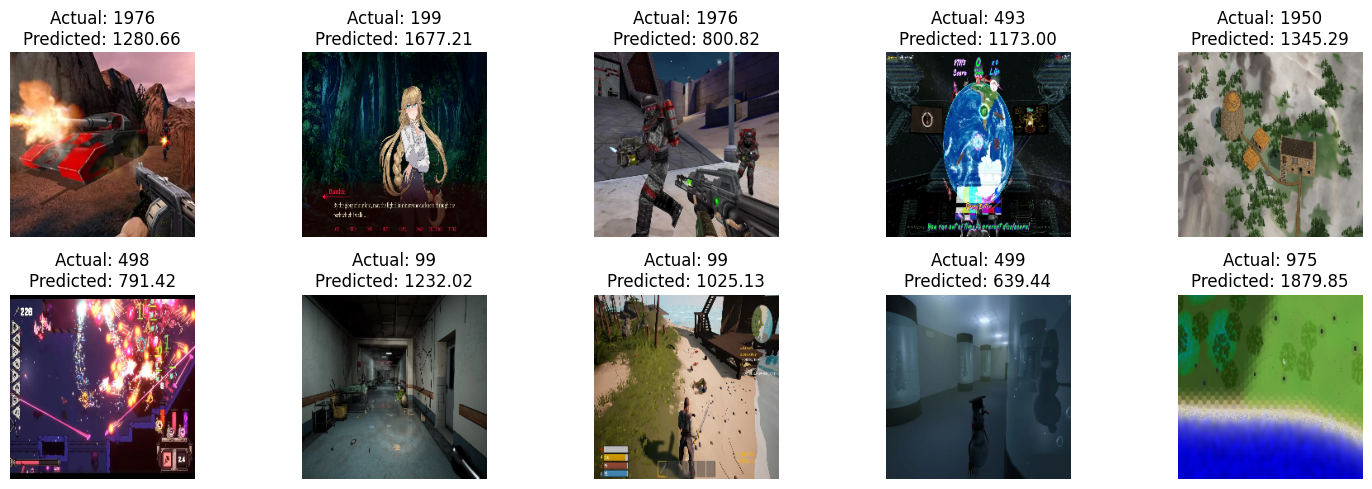

In [ ]:
# Plot the images with actual and predicted prices
def plot_predictions(df, num_images=10):
    num_rows = 2
    num_cols = num_images // num_rows
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    for i, (idx, row) in enumerate(df.sample(n=num_images, random_state=1).iterrows()):
        img_path = row['image_path']
        actual_price = row['price']
        predicted_price = row['prediction']
        
        # Load and preprocess the image
        img = load_and_preprocess_image(img_path)
        
        if img is not None:
            img = img.numpy()  # Convert to numpy array for plotting
            ax = axes[i // num_cols, i % num_cols]
            ax.imshow(img)
            ax.set_title(f"Actual: {actual_price}\nPredicted: {predicted_price:.2f}")
            ax.axis('off')
        else:
            ax = axes[i // num_cols, i % num_cols]
            ax.set_title(f"Failed to load image")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Apply the function
plot_predictions(test_games_expanded_prediction, num_images=10)

In [127]:
# Calculate MSE on test data 
from sklearn.metrics import mean_squared_error

actual_prices = test_games_expanded_prediction['price'].values
predicted_prices = test_games_expanded_prediction['prediction'].values
mse = mean_squared_error(actual_prices, predicted_prices)
print(mse)

813659.5838143951


In [128]:
prediction_means = test_games_expanded_prediction.groupby('appid')[['price', 'prediction']].mean().reset_index()
prediction_means

,appid,price,prediction
0,1479880,975.0,1288.408325
1,1576560,1479.0,1148.620972
2,1783930,1950.0,886.479492
3,1786930,1479.0,999.143738
4,1824580,2450.0,1058.439209
5,1843110,975.0,908.475159
6,1848070,1479.0,1067.835815
7,1978460,689.0,1066.936401
8,2155280,499.0,1214.908081
9,2160480,2450.0,1025.946167


In [129]:
# Calculate MSE on average price
actual_prices_mean = prediction_means['price'].values
predicted_prices_mean = prediction_means['prediction'].values
mse_mean = mean_squared_error(actual_prices_mean, predicted_prices_mean)
mse_mean

662249.7321781284

As shown by the illustration, the predictions on test dataset is not good as well. Due to the limited time and computational capability, we didn't try to tune the hyperparameters and we only used a small amount of the training data, which resulted in a poor performance. At the moment, we only considered each image as an isolate input to train the model and then average their prices. We ignored the different images for the same game might have different impact on the price. This is the direction we can work on in the future.

# Reference


* Anuraksoontorn, T. (2021, October 27). How to Estimate the Price of a Book by Its Cover Using Image Regression and CNN in Python. Medium. https://python.plainenglish.io/judge-the-book-price-by-its-cover-with-image-regression-using-cnns-python-770707e4fe67
* Keras. (n.d.). Keras documentation: VGG16 and VGG19. Keras.io. https://keras.io/api/applications/vgg/
* Mahendru, K. (2019, August 14). Loss Function | Loss Function In Machine Learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2019/08/detailed-guide-7-loss-functions-machine-learning-python-code/
* Olamendy, J. C. (2023, December 8). Understanding Early Stopping: A Key to Preventing Overfitting in Machine Learning. Medium. https://medium.com/@juanc.olamendy/understanding-early-stopping-a-key-to-preventing-overfitting-in-machine-learning-17554fc321ff
* Tensorflow. (n.d.). Data augmentation | TensorFlow Core. TensorFlow. https://www.tensorflow.org/tutorials/images/data_augmentation